## Problem statement

This project investigates whether public attention to renewable energy influences financial market volatility. As a quantifiable proxy for public interest, Google Trends data provides a useful tool for exploring this relationship empirically. Rather than analyzing a broad renewable energy index, the study focuses on the leading wind turbine manufacturer Vestas, allowing for a more targeted analysis in terms of company-specific and regional factors.

The central research question is:
“Can search interest in renewable energy, as measured by Google Trends data, affect market uncertainty and, by proxy, affect the stock price volatility of the wind turbine company Vestas?”


The initial hypothesis is that increased public interest in renewable energy is positively correlated with stock price volatility. This assumption is based on the idea that heightened search activity often coincides with both positive and negative news or developments that increase investor uncertainty and lead to greater price fluctuations. However, the direction and strength of this relationship are uncertain, motivating the need for an empirical analysis.

## Imports

In [282]:
library(quantmod)
library(xts)
library(rumidas)
library(rugarch)
library(tseries)
library(forecast)
library(aTSA)
library(zoo)

## Read datasets

As mentioned in the problem statement section, the data used was Google Trends data and financial data from the wind turbine company Vestas. 

### Google data

For the Google Trends data set, the group found a publicly available data set for Monthly Google Trends search volumes for keywords related to renewable energy. This is available via the International Energy Agency, and contains search volume data for 40 energy-related terms across 45 countries. The data set contains data from January 2010 to August 2022.

In [283]:
google_data <- read.csv("google_data.csv", header = TRUE, stringsAsFactors = FALSE)

### Vestas stock price data


To obtain financial data from Vestas, the group used the built-in function in R-code that retrieves historical financial data from the same period as the Google data, from Yahoo Finance. 

In [284]:

symbol <- "VWS.CO"  # Vestas Wind Systems (Copenhagen Stock Exchange)
start_date <- as.Date("2010-01-01")
end_date <- as.Date("2022-08-31")
getSymbols(symbol, src = "yahoo", from = start_date, to = end_date)
vestas_data <- Cl(get(symbol))  # Cl() extracts the closing prices
vestas_df <- data.frame(date = index(vestas_data), price = coredata(vestas_data))


[1] "VWS.CO"

## Clean and prepare the data

### European Google data

The data was cleaned by taking out what were considered less relevant words and countries outside of Europe. The words left in the dataset after this cleaning are given in the list below.
* Batteries
* Electric vehicle
* Electricity
* Electrification
* Geothermal
* Heat pump
* Hydroelectricity
* Hydrogen
* Nuclear
* Offshore wind
* Solar power
* Train
* Wind power

The cleaning of the Google trends data set also included selecting the relevant columns and removing the rest, to minimize redundant data. Further, the date format was converted to a proper date format, and aggregated to get an average for Europe. 

In [285]:
# Select only the relevant columns
google_data <- google_data[, c("country", "countryISO", "techSector", "year", "value")]

# Define the sectors you're interested in
tech_sectors <- c("Batteries", "Electric vehicle", "Electricity", "Electrification", 
                  "Geothermal", "Heat pump", "Hydroelectricity", "Hydrogen", 
                  "Nuclear", "Offshore wind", "Solar power", "Train", "Wind power")

# Filter for the selected tech sectors
google_data <- google_data[google_data$techSector %in% tech_sectors, ]

european_countries <- c("France", "Italy", "Sweden", "Austria", "Turkey", 
                         "Slovak Republic", "Belgium", "United Kingdom", 
                         "Portugal", "Ireland", "Switzerland", "Finland", 
                         "Norway", "Germany", "Netherlands")
google_data_european <- google_data[google_data$country %in% european_countries, ]


colnames(google_data)[colnames(google_data) == "year"] <- "date"

# Convert the date column into a proper date format
google_data$date <- as.Date(paste0(substr(google_data$date, 1, 2), 
                                   "-", substr(google_data$date, 3, 4), 
                                   "-01"), 
                            format = "%y-%m-%d")
# Convert back to Date type
google_data$date <- as.Date(google_data$date)

colnames(google_data_european)[colnames(google_data_european) == "year"] <- "date"
# Convert the date column into a proper date format for the European data
google_data_european$date <- as.Date(paste0(substr(google_data_european$date, 1, 2), 
                                             "-", substr(google_data_european$date, 3, 4), 
                                             "-01"), 
                                      format = "%y-%m-%d")
# Convert back to Date type for the European data
google_data_european$date <- as.Date(google_data_european$date)

# Aggregate: Compute average value for each month
google_monthly_avg <- aggregate(value ~ date, data = google_data, FUN = mean)
google_data_european_monthly_avg <- aggregate(value ~ date, data = google_data_european, FUN = mean)

head(google_monthly_avg)
head(google_data_european_monthly_avg)


,date,value
,<date>,<dbl>
1,2010-01-01,4.682794
2,2010-02-01,4.591593
3,2010-03-01,4.745969
4,2010-04-01,4.914769
5,2010-05-01,4.848954
6,2010-06-01,4.842765


,date,value
,<date>,<dbl>
1,2010-01-01,4.646908
2,2010-02-01,4.462741
3,2010-03-01,4.785163
4,2010-04-01,5.008614
5,2010-05-01,4.479021
6,2010-06-01,4.890323


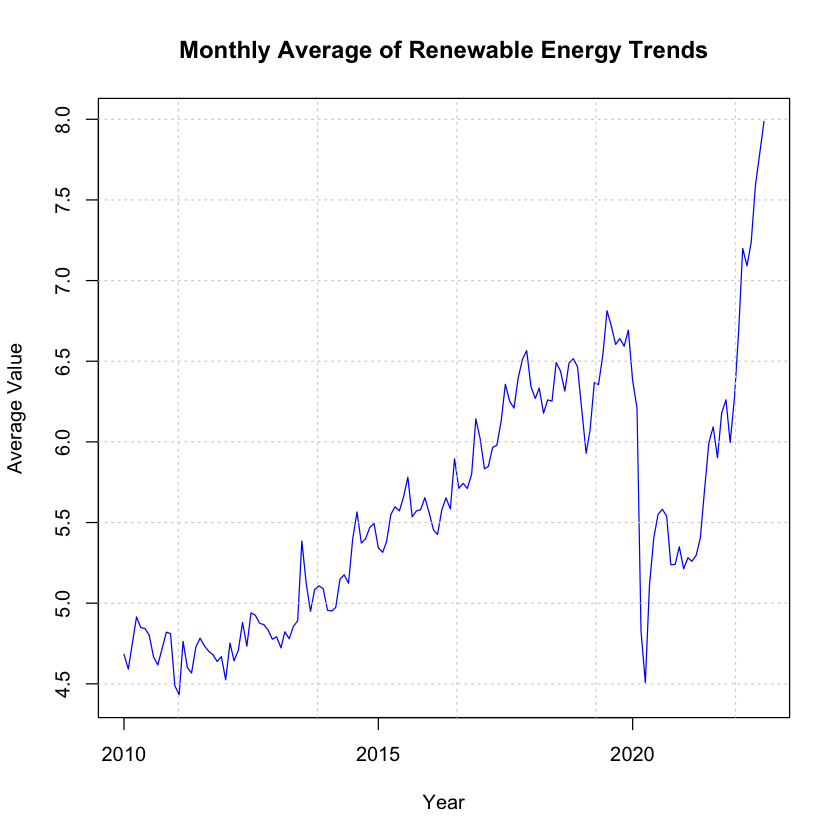

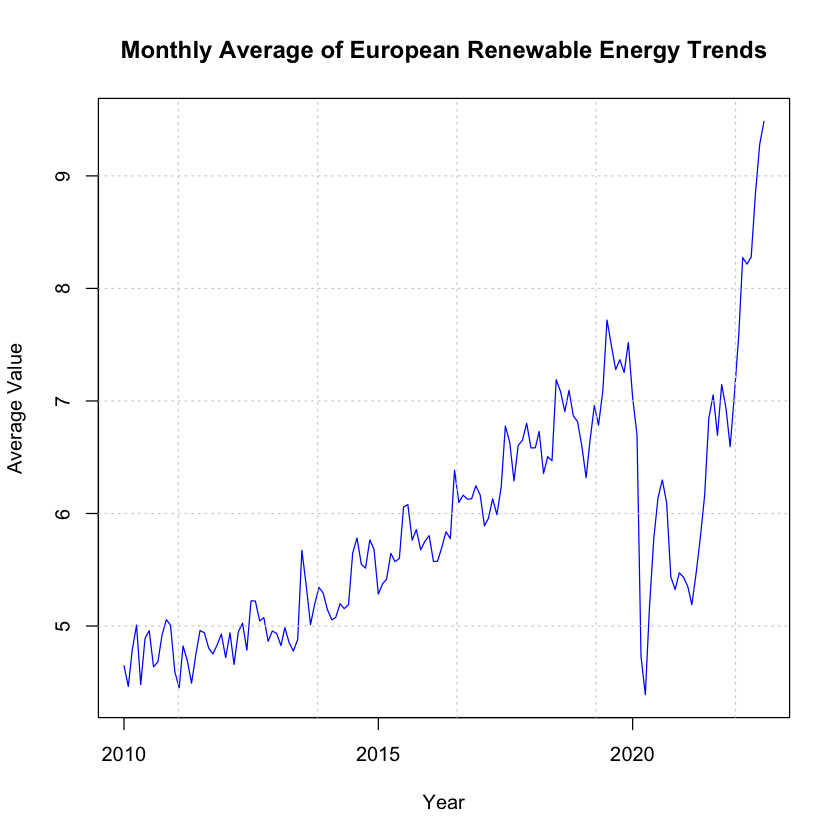

In [286]:
par(bg = "white")
plot(google_monthly_avg$date, google_monthly_avg$value, type = "l", col = "blue",
     xlab = "Year", ylab = "Average Value", main = "Monthly Average of Renewable Energy Trends")
# Add grid for better readability
grid()

par(bg = "white")
plot(google_data_european_monthly_avg$date, google_data_european_monthly_avg$value, type = "l", col = "blue",
     xlab = "Year", ylab = "Average Value", main = "Monthly Average of European Renewable Energy Trends")
# Add grid for better readability
grid()


,date,log_change
,<date>,<dbl>
1,2010-02-01,-0.04043891
2,2010-03-01,0.06975688
3,2010-04-01,0.04563916
4,2010-05-01,-0.11175477
5,2010-06-01,0.08785398
6,2010-07-01,0.01392989


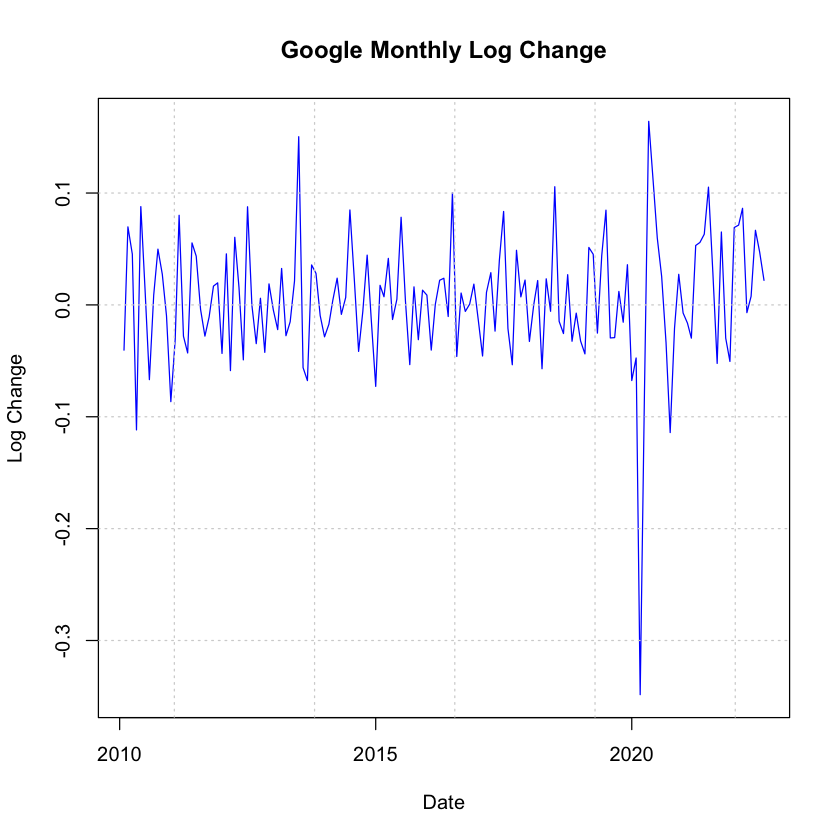

In [287]:
# Calculate the log returns (difference of log values)
google_monthly_european_log_change <- diff(log(google_data_european_monthly_avg$value))

# Create a new data frame with the corresponding dates and returns
google_monthly_european_log_change <- data.frame(date = google_data_european_monthly_avg$date[-1], 
                                                    log_change = google_monthly_european_log_change)

# View the first few rows of the new data frame
head(google_monthly_european_log_change)

# Plot the log change over time
par(bg = "white")
plot(google_monthly_european_log_change$date, google_monthly_european_log_change$log_change, 
     type = "l", col = "blue", 
     xlab = "Date", ylab = "Log Change", 
     main = "Google Monthly Log Change")

# Add grid for better readability
grid()


### Vestas stock price data

First, the code plots the data for visualization. Next, the code calculates the daily log returns by taking the difference in the natural logarithm of consecutive stock prices. These returns are stored in a new data frame alongside their corresponding dates and plotted to visualize fluctuations in daily returns. This serves as a measure of stock price volatility.

In [288]:
# Rename the column for easier access
colnames(vestas_df)[2] <- "price"
vestas_df$date <- as.Date(vestas_df$date)

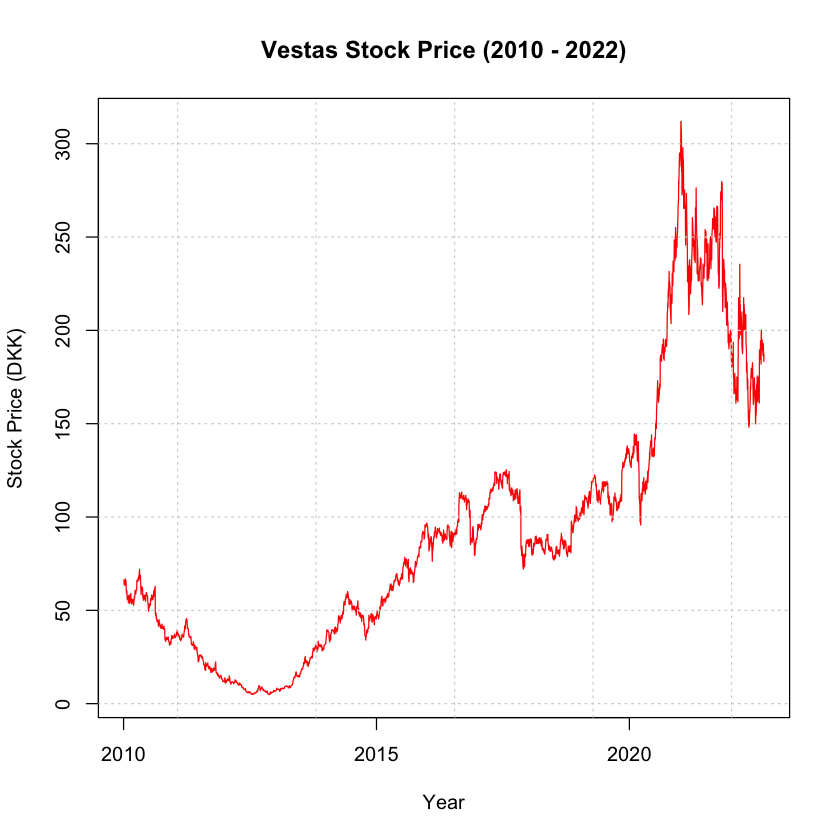

In [289]:
# Plot Vestas stock price over time
par(bg = "white")
plot(vestas_df$date, vestas_df$price, type = "l", col = "red",
     xlab = "Year", ylab = "Stock Price (DKK)", 
     main = "Vestas Stock Price (2010 - 2022)")
# Add grid for better readability
grid()


,date,log_return
,<date>,<dbl>
1,2010-01-05,-0.030894096
2,2010-01-06,-0.012503999
3,2010-01-07,0.008145356
4,2010-01-08,-0.004691162
5,2010-01-11,0.030866706
6,2010-01-12,-0.037155999


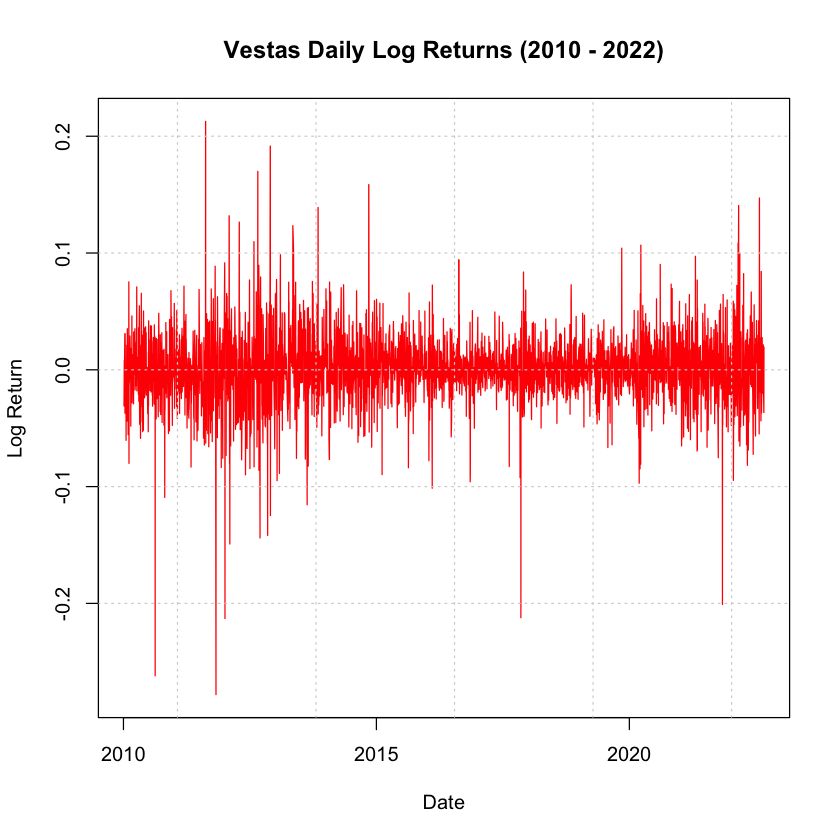

In [290]:
# Calculate the log returns (difference of log prices)
vestas_daily_returns <- diff(log(vestas_df$price))

# Create a new data frame with the corresponding dates and returns
vestas_returns_df <- data.frame(date = vestas_df$date[-1], log_return = vestas_daily_returns)

# View the data frame
head(vestas_returns_df)

# Plot the log returns over time
par(bg = "white")
plot(vestas_returns_df$date, vestas_returns_df$log_return, type = "l", col = "red", 
     xlab = "Date", ylab = "Log Return", 
     main = "Vestas Daily Log Returns (2010 - 2022)")

# Add grid for better readability
grid()

### Transfrom data to xts

Both trend data and financial data is converted into xts time-series objects, allowing for easier alignment and analysis of the two datasets in time-series models.

#### European Google data

In [291]:
google_monthly_avg_xts <- xts(google_monthly_european_log_change$log_change, order.by = google_monthly_european_log_change$date)
colnames(google_monthly_avg_xts) <- "value"
head(google_monthly_avg_xts)

                 value
2010-02-01 -0.04043891
2010-03-01  0.06975688
2010-04-01  0.04563916
2010-05-01 -0.11175477
2010-06-01  0.08785398
2010-07-01  0.01392989

#### Vestas log return data

In [292]:
vestas_daily_returns_xts <- xts(vestas_returns_df$log_return, order.by = vestas_returns_df$date)
colnames(vestas_daily_returns_xts) <- "return"
head(vestas_daily_returns_xts)

                 return
2010-01-05 -0.030894096
2010-01-06 -0.012503999
2010-01-07  0.008145356
2010-01-08 -0.004691162
2010-01-11  0.030866706
2010-01-12 -0.037155999

## Data understanding

#### Normality


	Jarque Bera Test

data:  vestas_returns_df$log_return
X-squared = 11842, df = 2, p-value < 0.00000000000000022


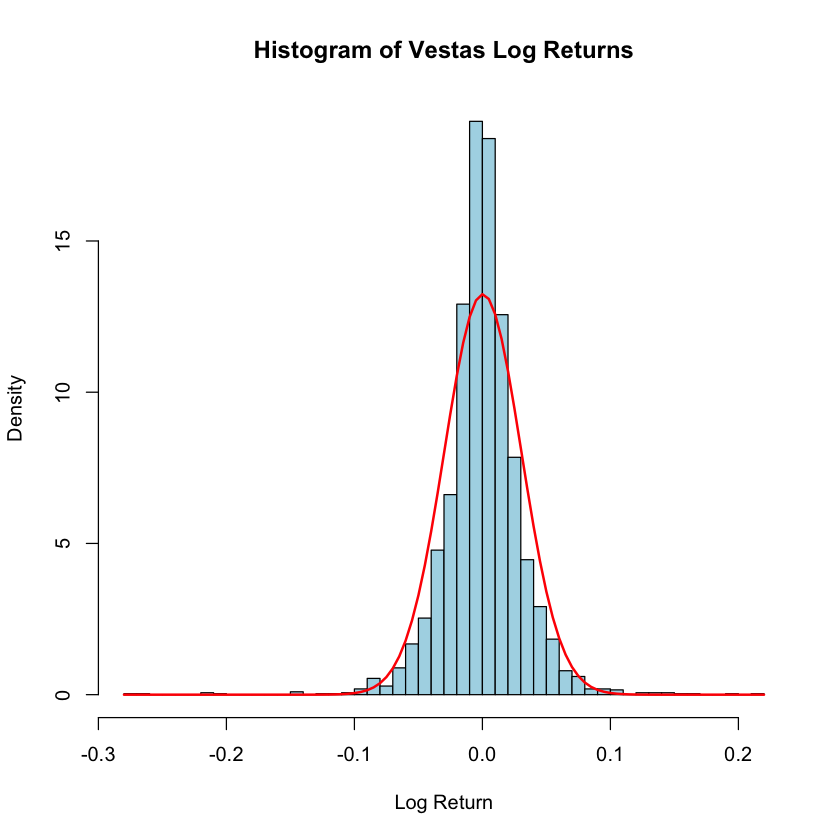

In [293]:
hist(vestas_returns_df$log_return, breaks = 50, probability = TRUE, 
     main = "Histogram of Vestas Log Returns", xlab = "Log Return", col = "lightblue")

# Overlay a normal density curve
curve(dnorm(x, mean = mean(vestas_returns_df$log_return), 
            sd = sd(vestas_returns_df$log_return)), 
      col = "red", lwd = 2, add = TRUE)

jarque.bera.test(vestas_returns_df$log_return)


	Jarque Bera Test

data:  google_monthly_european_log_change$log_change
X-squared = 590.13, df = 2, p-value < 0.00000000000000022


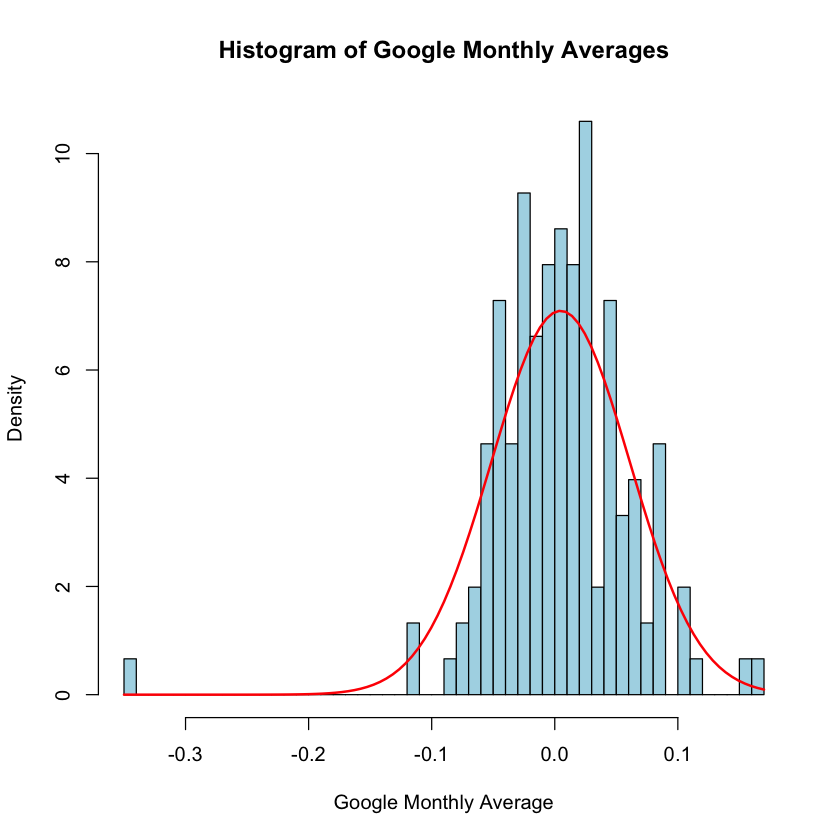

In [294]:
# 1. Create the histogram for Google monthly average values
hist(google_monthly_european_log_change$log_change,  # Using the 'log_change' column from the xts object
     breaks = 50,                   # Number of bins
     probability = TRUE,            # Scale the y-axis to probability density
     main = "Histogram of Google Monthly Averages",  # Title of the plot
     xlab = "Google Monthly Average",  # X-axis label
     col = "lightblue")             # Color of the bars

# 2. Overlay the normal density curve based on the Google data
curve(dnorm(x, mean = mean(google_monthly_european_log_change$log_change),  # Mean of the data
            sd = sd(google_monthly_european_log_change$log_change)),        # Standard deviation of the data
      col = "red",                    # Color of the curve
      lwd = 2,                        # Line width
      add = TRUE)                     # Add the curve on top of the histogram

jarque.bera.test(google_monthly_european_log_change$log_change)

#### Autocorrelation

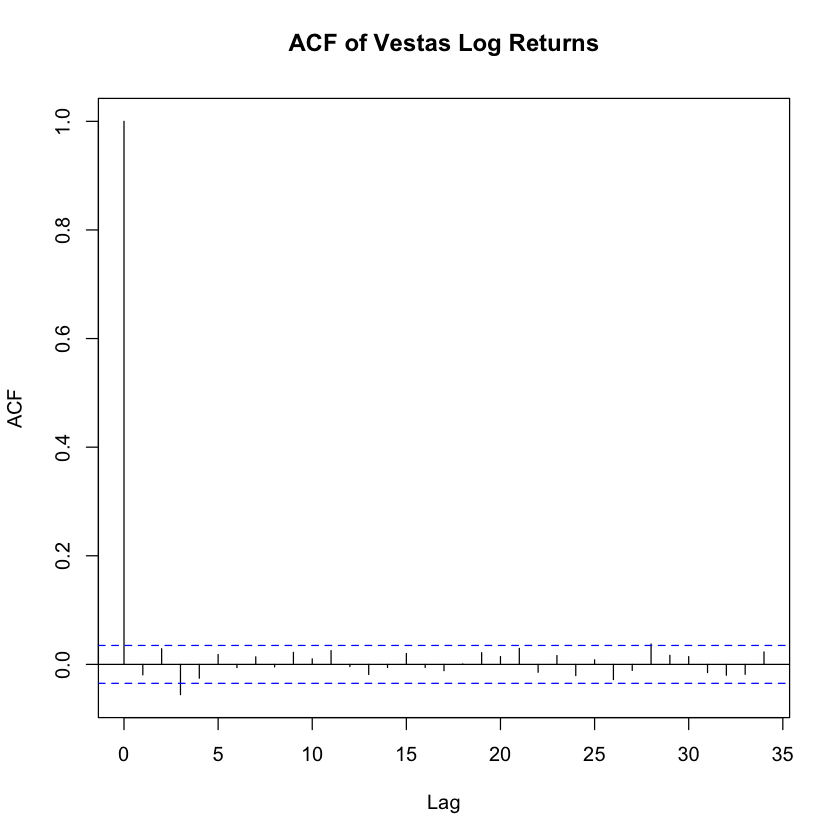

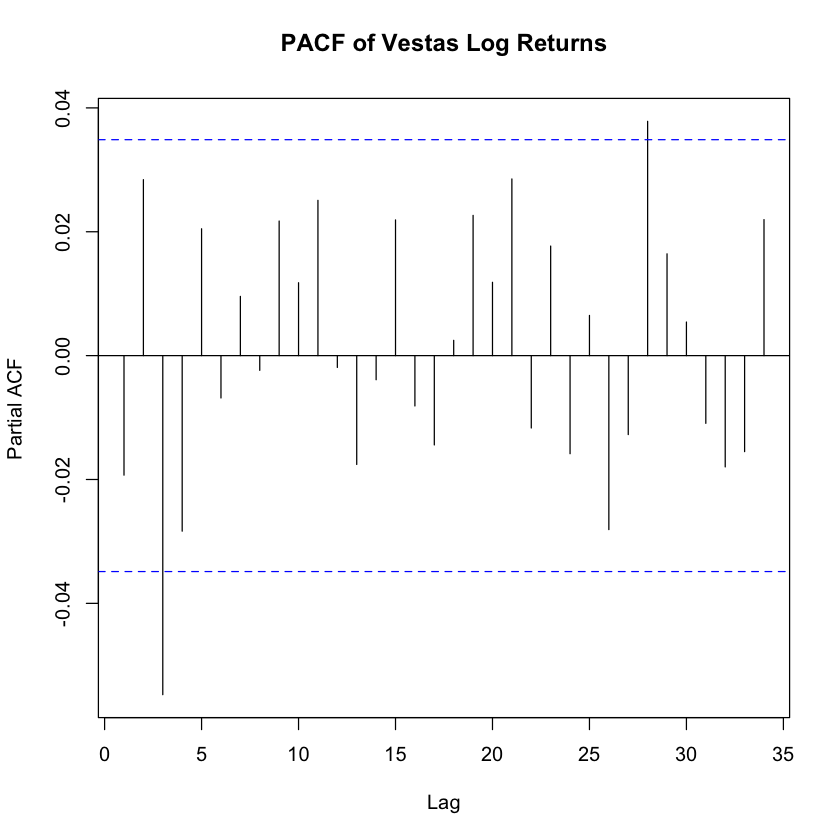

In [295]:
acf(vestas_returns_df$log_return, main = "ACF of Vestas Log Returns")
pacf(vestas_returns_df$log_return, main = "PACF of Vestas Log Returns")

#### Stationarity

In [296]:
# Test for stationarity on log returns
adf.test(vestas_returns_df$log_return)

Augmented Dickey-Fuller Test 
alternative: stationary 
 
Type 1: no drift no trend 
      lag   ADF p.value
 [1,]   0 -57.3    0.01
 [2,]   1 -39.0    0.01
 [3,]   2 -33.8    0.01
 [4,]   3 -29.8    0.01
 [5,]   4 -25.8    0.01
 [6,]   5 -23.6    0.01
 [7,]   6 -21.5    0.01
 [8,]   7 -20.1    0.01
 [9,]   8 -18.5    0.01
Type 2: with drift no trend 
      lag   ADF p.value
 [1,]   0 -57.3    0.01
 [2,]   1 -39.0    0.01
 [3,]   2 -33.8    0.01
 [4,]   3 -29.8    0.01
 [5,]   4 -25.8    0.01
 [6,]   5 -23.6    0.01
 [7,]   6 -21.5    0.01
 [8,]   7 -20.1    0.01
 [9,]   8 -18.5    0.01
Type 3: with drift and trend 
      lag   ADF p.value
 [1,]   0 -57.3    0.01
 [2,]   1 -39.0    0.01
 [3,]   2 -33.8    0.01
 [4,]   3 -29.8    0.01
 [5,]   4 -25.8    0.01
 [6,]   5 -23.6    0.01
 [7,]   6 -21.6    0.01
 [8,]   7 -20.2    0.01
 [9,]   8 -18.6    0.01
---- 
Note: in fact, p.value = 0.01 means p.value <= 0.01 


In [297]:
# Test for stationarity on log returns
adf.test(google_monthly_european_log_change$log_change)

Augmented Dickey-Fuller Test 
alternative: stationary 
 
Type 1: no drift no trend 
     lag    ADF p.value
[1,]   0 -11.28    0.01
[2,]   1 -10.42    0.01
[3,]   2  -7.73    0.01
[4,]   3  -7.35    0.01
[5,]   4  -6.51    0.01
Type 2: with drift no trend 
     lag    ADF p.value
[1,]   0 -11.32    0.01
[2,]   1 -10.49    0.01
[3,]   2  -7.81    0.01
[4,]   3  -7.50    0.01
[5,]   4  -6.65    0.01
Type 3: with drift and trend 
     lag    ADF p.value
[1,]   0 -11.31    0.01
[2,]   1 -10.51    0.01
[3,]   2  -7.85    0.01
[4,]   3  -7.52    0.01
[5,]   4  -6.72    0.01
---- 
Note: in fact, p.value = 0.01 means p.value <= 0.01 


#### Heteroskedasticity

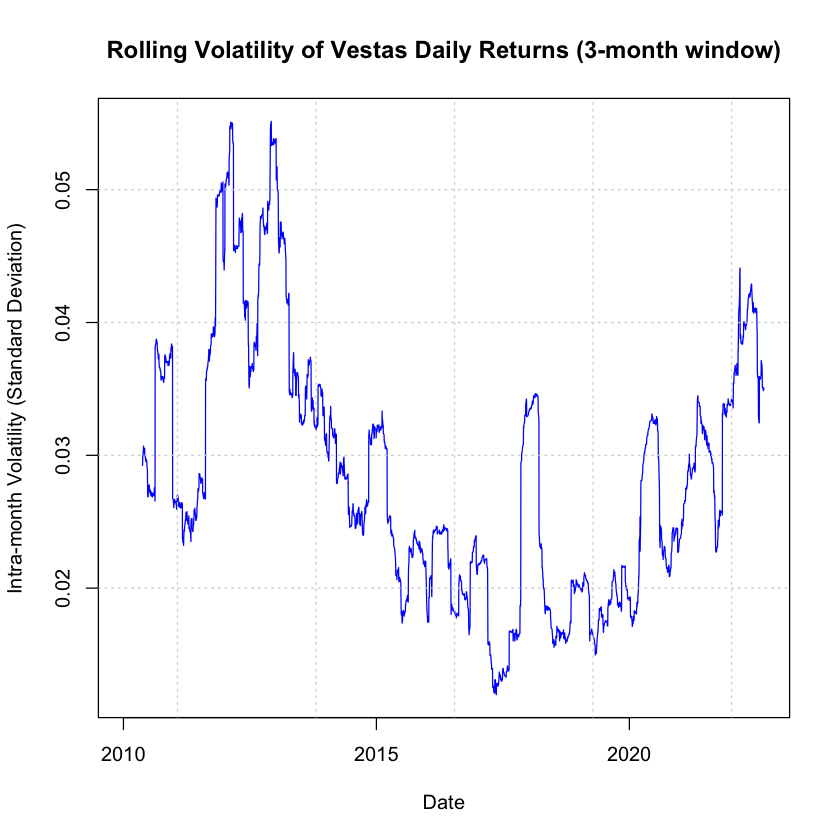

In [298]:
# Choose a rolling window size for intra-month volatility
window_size <- 90

# Calculate the rolling standard deviation (volatility) using rollapply
rolling_volatility_intra_month <- rollapply(vestas_daily_returns_xts, 
                                            width = window_size, 
                                            FUN = sd, 
                                            align = "right", 
                                            fill = NA)

# Plot the rolling volatility
plot(index(rolling_volatility_intra_month), rolling_volatility_intra_month, 
     type = "l", col = "blue", 
     xlab = "Date", ylab = "Intra-month Volatility (Standard Deviation)", 
     main = "Rolling Volatility of Vestas Daily Returns (3-month window)")

grid()

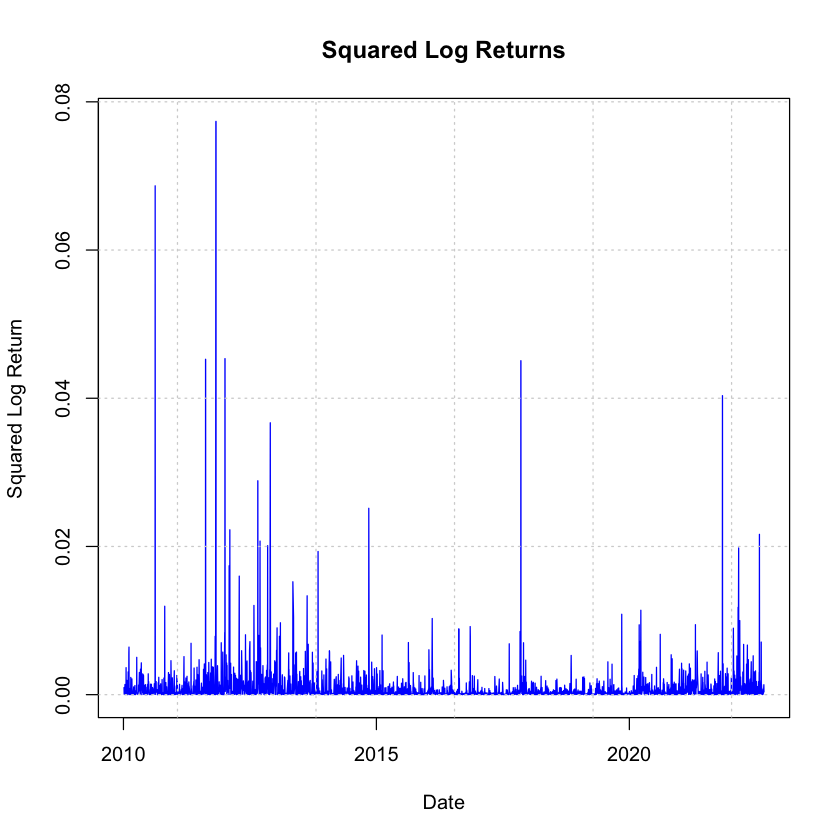

In [299]:
plot(vestas_returns_df$date, vestas_returns_df$log_return^2, 
     type = "l", col = "blue", 
     xlab = "Date", ylab = "Squared Log Return", 
     main = "Squared Log Returns")
grid()

ARCH heteroscedasticity test for residuals 
alternative: heteroscedastic 

Portmanteau-Q test: 
     order   PQ     p.value
[1,]     4 33.5 0.000000923
[2,]     8 44.4 0.000000468
[3,]    12 49.7 0.000001592
[4,]    16 60.4 0.000000446
[5,]    20 67.7 0.000000425
[6,]    24 78.5 0.000000107
Lagrange-Multiplier test: 
     order   LM p.value
[1,]     4 7416       0
[2,]     8 3536       0
[3,]    12 2320       0
[4,]    16 1704       0
[5,]    20 1347       0
[6,]    24 1096       0
     order       PQ         p.value       LM p.value
[1,]     4 33.54598 0.0000009232994 7416.016       0
[2,]     8 44.44807 0.0000004681279 3536.240       0
[3,]    12 49.67644 0.0000015923085 2319.981       0
[4,]    16 60.41241 0.0000004459303 1703.798       0
[5,]    20 67.73608 0.0000004247144 1346.944       0
[6,]    24 78.46310 0.0000001067176 1096.485       0
ARCH heteroscedasticity test for residuals 
alternative: heteroscedastic 

Portmanteau-Q test: 
     order   PQ     p.value
[1,]     4 33.5 0.

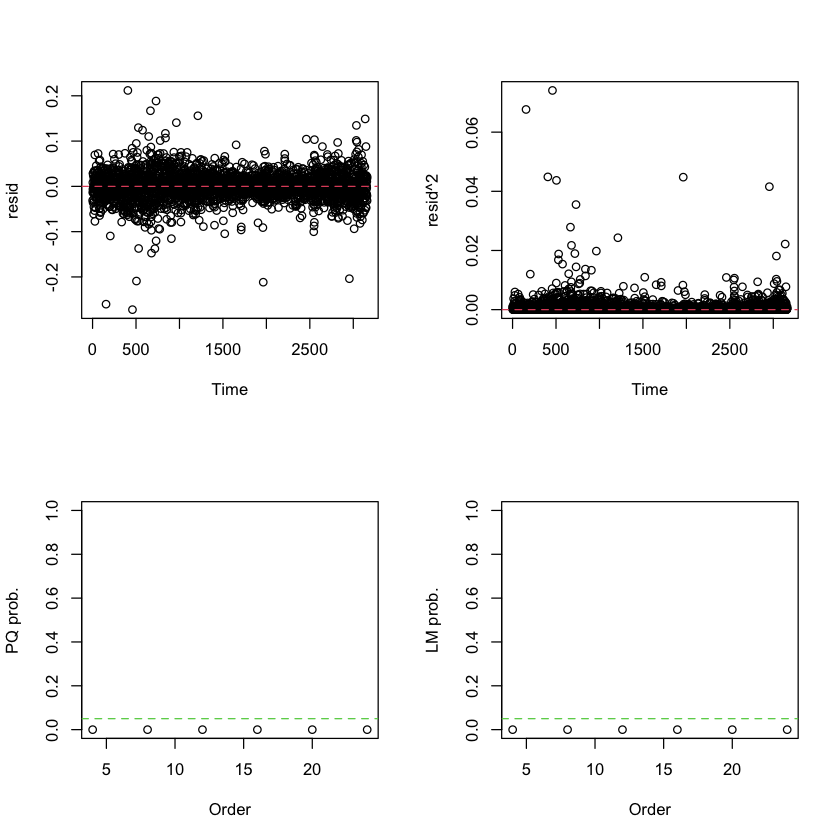

In [300]:
# Step 1: Fit an ARIMA model to your data (you can adjust the order)
model <- arima(vestas_daily_returns_xts, order = c(30, 0, 0))  # Example AR(5) model

# Step 2: Perform Engle’s ARCH test
arch_result <- arch.test(model)

# Step 3: View the results of the ARCH test
print(arch_result)

# Optional Step 4: Visualize residuals, squared residuals, and p-values of tests
arch.test(model, output = TRUE)

# Interpretation:
# - If p-value of the LM test is less than 0.05, there is evidence of heteroscedasticity (ARCH effect).
# - If p-value of the PQ test is less than 0.05, the residuals are not white noise (ARCH effect).


## Garch-Midas

GARCH-MIDAS is a GARCH model that enables use of data with different frequencies, allowing the model to compare low-frequency macro data with high-frequency financial data. The model can therefore examine the effect of macroeconomic variables on a stock volatility. This makes it an ideal model for the project, as the Google Trends data is only available on a monthly basis.

### Fitting the model

This part of the code aligns daily return data with monthly average data by trimming the daily data to match a specific time window. It first sets a starting point K months into the monthly data and updates the daily data to start from that date if needed. Then, it ensures the daily data doesn't extend beyond the last date of the monthly data. This prepares both datasets for consistent time alignment when fitting the model.

In [301]:
K_values <- c(3, 6, 9, 12)
distributions <- c("norm", "std") #Removed "ged" because of error
lag_functions <- c("Beta", "Almon") #removed "expalmon" Because error

results <- list()

for (K in K_values) {
  for (dist in distributions) {
    for (lag_fun in lag_functions) {
      model_key <- paste0("K", K, "_", dist, "_", lag_fun)
      cat(sprintf("Fitting GM: %s\n", model_key))
      
      tryCatch({
        # Adjust starting point for K
        start_monthly <- index(google_monthly_avg_xts)[1]
        new_start_date <- as.Date(seq(start_monthly, by = "month", length.out = K + 1)[K + 1])
        
        adj_returns <- vestas_daily_returns_xts
        if (index(adj_returns)[1] < new_start_date) {
          adj_returns <- adj_returns[new_start_date <= index(adj_returns)]
        }
        
        # Align with end date
        end_monthly <- index(google_monthly_avg_xts)[length(google_monthly_avg_xts)]
        if (index(adj_returns)[length(adj_returns)] > end_monthly) {
          adj_returns <- adj_returns[index(adj_returns) <= end_monthly]
        }
        
        mv_m <- mv_into_mat(
          x = adj_returns$return,
          mv = google_monthly_avg_xts,
          K = K,
          type = "monthly"
        )
        
        model <- ugmfit(
          model = "GM",
          skew = "NO",
          distribution = dist,
          daily_ret = adj_returns$return,
          mv_m = mv_m,
          K = K,
          lag_fun = lag_fun
        )
        
        results[[model_key]] <- list(
          model = model,
          AIC = model$inf_criteria["AIC"],
          BIC = model$inf_criteria["BIC"]
        )
        
        cat(sprintf("AIC: %.2f | BIC: %.2f\n\n", model$inf_criteria["AIC"], model$inf_criteria["BIC"]))
        
      }, error = function(e) {
        cat(sprintf("Error in model %s: %s\n", model_key, e$message))
      })
    }
  }
}

Fitting GM: K3_norm_Beta
AIC: -13147.24 | BIC: -13117.11

Fitting GM: K3_norm_Almon
AIC: -13125.02 | BIC: -13094.89

Fitting GM: K3_std_Beta
AIC: -17202.26 | BIC: -17166.10

Fitting GM: K3_std_Almon
AIC: -17202.25 | BIC: -17166.09

Fitting GM: K6_norm_Beta
AIC: -12927.22 | BIC: -12897.20

Fitting GM: K6_norm_Almon
Error in model K6_norm_Almon: Lapack routine dgesv: system is exactly singular: U[5,5] = 0
Fitting GM: K6_std_Beta
AIC: -16856.67 | BIC: -16820.64

Fitting GM: K6_std_Almon
AIC: -16854.69 | BIC: -16818.66

Fitting GM: K9_norm_Beta
AIC: -12706.43 | BIC: -12676.51

Fitting GM: K9_norm_Almon
Error in model K9_norm_Almon: Lapack routine dgesv: system is exactly singular: U[5,5] = 0
Fitting GM: K9_std_Beta
AIC: -16517.66 | BIC: -16481.76

Fitting GM: K9_std_Almon
AIC: -16186.50 | BIC: -16150.60

Fitting GM: K12_norm_Beta
AIC: -12427.17 | BIC: -12397.36

Fitting GM: K12_norm_Almon
AIC: -12426.22 | BIC: -12396.41

Fitting GM: K12_std_Beta
AIC: -16158.83 | BIC: -16123.06

Fitting GM:

In [302]:
#find the best model
best_model <- NULL
best_aic <- Inf
best_bic <- Inf
best_model_key <- NULL
for (key in names(results)) {
  model_info <- results[[key]]
  if (model_info$AIC < best_aic) {
    best_aic <- model_info$AIC
    best_model <- model_info$model
    best_model_key <- key
  }
  if (model_info$BIC < best_bic) {
    best_bic <- model_info$BIC
  }
}
cat(sprintf("Best Model: %s\n", best_model_key))
cat(sprintf("Best AIC: %.2f\n", best_aic))
cat(sprintf("Best BIC: %.2f\n", best_bic))
# Print the best model summary
cat(sprintf("Best Model Summary:\n"))
#print summry.rumidas(best_model))
summary.rumidas(best_model)   

Best Model: K3_std_Beta


Best AIC: -17202.26
Best BIC: -17166.10
Best Model Summary:

Coefficients:
      Estimate Std. Error  t value Pr(>|t|) Sig.
alpha   0.0329     0.0136   2.4224   0.0154   **
beta    0.9649     0.0153  63.0315   0.0000  ***
m      -6.3838     0.1073 -59.4920   0.0000  ***
theta   1.5424     0.1203  12.8175   0.0000  ***
w2      3.2527     0.1428  22.7826   0.0000  ***
shape   3.8594     0.0801  48.1944   0.0000  ***
--- 
Signif. codes: 0.01 '***', 0.05 '**', 0.1 '*' 

Obs.: 3060. Sample Period: 2010-05-03/2022-08-01 
MSE(%): 0.000952;  QLIKE: -6.132842 



## Conclusion

The results show slight positive correlation that is statistically significant. This indicates that search trends for energy terms can explain some of the stock price volatility for Vestas. A slight positive correlation suggests that increased public attention, as captured by Google Trends data, may signal slightly heightened uncertainty or market reactions. This is possibly triggered by news, policy changes, or events related to renewable energy. When attention spikes, it may reflect a flow of new information or investor sentiment shifts, both of which can lead to more trading activity and price fluctuations. This aligns with the idea and initial hypothesis that greater public awareness, especially during periods of debate or disruption in the renewable energy sector, can lead to some increase in volatility. However, most of the volatility is driven by other factors.

In extension of the discussion above, there is reason to reflect on what other factors Vestas’ stock price is affected by in addition to retail investors and public opinion. We cannot draw any causality conclusions, as a variety of other factors may have affected the in-sample results. Furthermore, considering the fact that 85% (https://www.vestas.com/en/investor/share-and-capital-structure/share-information#accordion-7647c6cd9b-item-2a7d04ede7) of Vestas is held by institutional investors, one could also assume that the traded volume driving price discovery is majorly institutional. Hence, even if our findings were generalizable and robust out of sample, it would still be hard to draw causal conclusions, as the price and google search data are driven by largely independent factors. 

## Use of LLM
